## [H重點]
了解如何使用 Sklearn 中的 hyper-parameter search 找出最佳的超參數

### H
請使用不同的資料集，並使用 hyper-parameter search 的方式，看能不能找出最佳的超參數組合

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

train_X = df.values
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=42)

# 建立模型
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
# 將隨機森林結果輸出
pred_rf = estimator.predict(x_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf)

### Hyperparameter

In [38]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 設定要訓練的超參數組合
n_estimators = [50,100, 200, 300, 400]
max_depth = [1,2, 3,4, 5,6,7,8,9,10 ]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(estimator, param_grid, n_jobs=7, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

# 預設會跑 3-fold cross-validadtion，總共 9 種參數組合，總共要 train 27 次模型

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done 100 tasks      | elapsed:    4.6s
[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed:    7.1s finished


In [39]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.823353 using {'max_depth': 10, 'n_estimators': 400}


In [40]:
# 使用最佳參數重新建立模型
bestparam = RandomForestClassifier(max_depth=grid_result.best_params_['max_depth'],
                                           n_estimators=grid_result.best_params_['n_estimators'])

# 訓練模型
bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = bestparam.predict(x_test)

In [41]:
best_fpr_rf, best_tpr_rf, _ = roc_curve(y_test, y_pred)

In [42]:
from sklearn.metrics import accuracy_score

print("Origin Accuracy: %f " % (accuracy_score(y_test, pred_rf)))
print("Best Accuracy: %f " % (accuracy_score(y_test, y_pred)))

Origin Accuracy: 0.834081 
Best Accuracy: 0.834081 


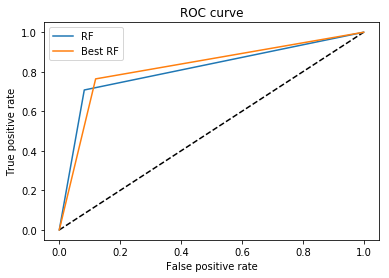

In [43]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(best_fpr_rf, best_tpr_rf, label='Best RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()